<a href="https://colab.research.google.com/github/wuchenyu38/Is20f/blob/master/chenyu/Variance_Gamma_FFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.integrate import quad

$$
C_T(k)=\frac{e^{-\alpha k}}{\pi}\int_0^\infty e^{-ivk}\psi(v)dv
$$

In [59]:
class FTCall:
    def __init__(self, model):
        self.md = model
        
    #$\psi$ function for carr-madan method
    def psi(self, w, T, alpha):
        o1 = np.exp(-self.md.r*T)
        o1 = o1*self.md.charfun(T, w - (alpha+1)*1j)
        o2 = alpha**2+alpha-w**2+1j*(2*alpha+1.)*w
        return o1/o2
    
    #carr-madan method with damping
    def price_cm(self, K, T, alpha = 1.5):
        k = np.log(K)
        integrand = lambda w: (np.exp(-1j*w*k)*self.psi(w, T, alpha)).real
        integral = quad(integrand, 0, np.inf)[0]
        return np.exp(-alpha*k)/np.pi*integral

$$
\psi_T(v)=\frac{e^{-rT}\Phi_T(v-(\alpha+1)i)}{\alpha^2+\alpha-v^2+i(2\alpha+1)v}
$$

$$
\phi_T(u)=[S_0e^{(r+\omega)T]}]^{iu}(1-i\theta vu+\frac{1}{2}\sigma^2 u^2v)^{-\frac{T}{v}}
$$

In [100]:
class VG:
    def __init__(self, S0, r, sigma, theta, v):
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.theta = theta
        self.v = v
        
    #characteristic function for $ln S_T$
    def charfun(self, T, u):
        omega = (1/self.v)*np.log(1-self.theta*self.v-0.5*self.sigma**2*self.v)
        phi = (self.S0*np.exp((self.r+omega)*T))**(1j*u)*(1-1j*self.theta*self.v*u+1/2*self.sigma**2*u**2*self.v)**(-T/self.v)
        return phi

In [143]:
%%time
vg = VG(100, 0.0475, 0.2, 3, 0.061)
ftc = FTCall(vg)
ans = ftc.price_cm(110, 1, alpha = 1.5)
print(
      f'VG FT price by carr-madan is \n >> {ans}'
      )

VG FT price by carr-madan is 
 >> 31.328700593999912
CPU times: user 3.89 ms, sys: 0 ns, total: 3.89 ms
Wall time: 3.78 ms


In [109]:
def charfun(u):
    T = 1
    r = 0.0475
    theta = 3
    S0 = 100
    sigma = 0.2
    v = 0.061
    omega = (1/v)*np.log(1-theta*v-0.5*sigma**2*v)
    phi = (S0*np.exp((r+omega)*T))**(1j*u)*(1-1j*theta*v*u+1/2*sigma**2*u**2*v)**(-T/v)
    return phi

In [110]:
def SimpsonW(N,eta):
    delt = np.zeros(N, dtype=np.float)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = eta*(3 + (-1) ** j - delt) / 3
    return SimpsonW

In [111]:
def psi(w, T, alpha, r):
    o1 = np.exp(-r*T)
    o1 = o1*charfun(w - (alpha+1)*1j)
    o2 = alpha**2+alpha-w**2+1j*(2*alpha+1.)*w
    return o1/o2

In [112]:
def VG_NumpyFFT(S0, K, T):
    k = np.log(K)
    x0 = np.log(S0)
    N =2**10
    alpha=1.5
    
    eta=0.15
    lambda_ = 2 * np.pi / (N *eta)
    beta=x0-lambda_*N/2
    km=np.asarray([beta+i*lambda_ for i in range(N)])
    W=SimpsonW(N,eta)
    v=np.asarray([i*eta for i in range(N)])
    Psi=np.asarray([psi(vj, T, alpha, 0)  for vj in v])
    FFTFunc=Psi*np.exp(-1j*beta*v)*W
    
    
    y=np.fft.fft(FFTFunc).real
    
    
    cT=np.exp(-alpha*km)*y/np.pi
    return cT

In [140]:
%%time
print(
      f'VG FFT price by carr-madan is \n >> {VG_NumpyFFT(100, 110, 1)[515]}'
      )

VG FFT price by carr-madan is 
 >> 31.99518622737168
CPU times: user 27.9 ms, sys: 740 µs, total: 28.6 ms
Wall time: 29.9 ms


In [114]:
S0 = 100.0  # index level
N =2**10 
eta=0.15
lambda_ = 2 * np.pi / (N *eta)
x0 = np.log(S0)
beta=x0-lambda_*N/2
k=np.asarray([np.e**(beta+lambda_*n) for n in range(N)])

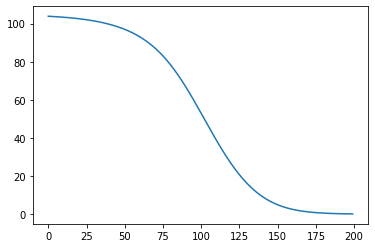

In [119]:
import matplotlib.pyplot as plt
plt.plot(VG_NumpyFFT(100, 110, 1)[400:600]) 
plt.show()

In [138]:
#Verification based on the book (Analytical Method)
Verify_VG = VG(100, 0.1, 0.12, -0.14, 0.2)
Verify_Call = FTCall(Verify_VG)
Kv = 10
call_option_price = [] 
for i in range (10):
  call_option_price.append(Verify_Call.price_cm(Kv, 1/12, alpha = 1.5)) 
  Kv = Kv + 10

call_option_price

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  app.launch_new_instance()


[90.08409184340738,
 80.1826364596626,
 70.25883894438714,
 60.330122095468134,
 50.41558217226299,
 40.49808070615871,
 30.58130804666516,
 20.670417652778628,
 10.828867975353846,
 1.8149982036650307]

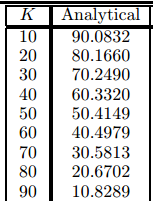